In [1]:
from time import time

import numpy as np
import pandas as pd
from new_SPOC import *
import old_SPOC as old_SPOC
from generate_SPOC_model import *
import matplotlib.pyplot as plt
import matplotlib
import matlab.engine

from tqdm import tqdm_notebook, tqdm
from IPython.display import clear_output, display
import random

%matplotlib inline
eng = matlab.engine.start_matlab()

In [2]:
methods = {"SPOC": lambda A, n_clusters: SPOC(A, n_clusters, use_ellipsoid=False, use_cvxpy=False),
           "GeoNMF": lambda A, n_clusters: eng.GeoNMF(A, n_clusters, 0.25, 0.95, nargout=2),
           "SPOC_bootstrap": lambda A, n_clusters: SPOC_bootstrap(A, n_clusters, n_repetitions=10, std_num=3),
          }

In [18]:
n_clusters = 3
n_repetitions = 5
pn_number = n_clusters
random_vec = np.random.rand(3,)

EXP_DATA = pd.DataFrame(columns=["n_nodes", "n_clusters", "pure_nodes_number",\
                                 "seed", "method", "matrix", "error", "time"])

for n_nodes in np.arange(200, 550, 50):
    for repeat in tqdm_notebook(range(n_repetitions)):
        
        random.seed(repeat)
        np.random.seed(repeat)
        random_vec = 0.5 * np.random.rand(3,)
        B = np.diag([0.5] * 3 + random_vec)
        B = B / np.max(B)

        Theta = generate_theta(n_nodes=n_nodes, n_clusters=n_clusters, pure_nodes_number=pn_number, seed=repeat)
        P = Theta.dot(B).dot(Theta.T)
        A = P_to_A(P, seed=repeat)

        for method_name in methods: 
            if method_name == "GeoNMF":
                A = matlab.double(A.tolist())

            time_start = time()
            theta, b = methods[method_name](A, n_clusters)
            time_end = time()
            theta = np.array(theta)
            b = np.array(b)

            err, _ = find_permutation_Theta(Theta, theta)
            EXP_DATA = EXP_DATA.append({"n_nodes": n_nodes, "n_clusters": n_clusters,\
                                        "pure_nodes_number": pn_number, "seed":repeat,\
                                        "method":method_name, "matrix":"Theta", "error":err,\
                                        "time": time_end - time_start}, ignore_index=True)

            err, _ = find_permutation_B(B, b)
            EXP_DATA = EXP_DATA.append({"n_nodes": n_nodes, "n_clusters": n_clusters,\
                                        "pure_nodes_number": pn_number, "seed": repeat,\
                                        "method": method_name, "matrix": "B", "error": err,\
                                        "time": time_end - time_start}, ignore_index=True)

    EXP_DATA.to_csv("n_nodes.csv", index=None)

In [22]:
EXP_DATA.head()

,n_nodes,n_clusters,pure_nodes_number,seed,method,matrix,error,time
0,200,3,3,0,SPOC_bootstrap,Theta,0.117294,0.248337
1,200,3,3,0,SPOC_bootstrap,B,0.267212,0.248337
2,200,3,3,0,SPOC,Theta,0.124813,0.010415
3,200,3,3,0,SPOC,B,0.146124,0.010415
4,200,3,3,0,GeoNMF,Theta,0.110028,0.637600


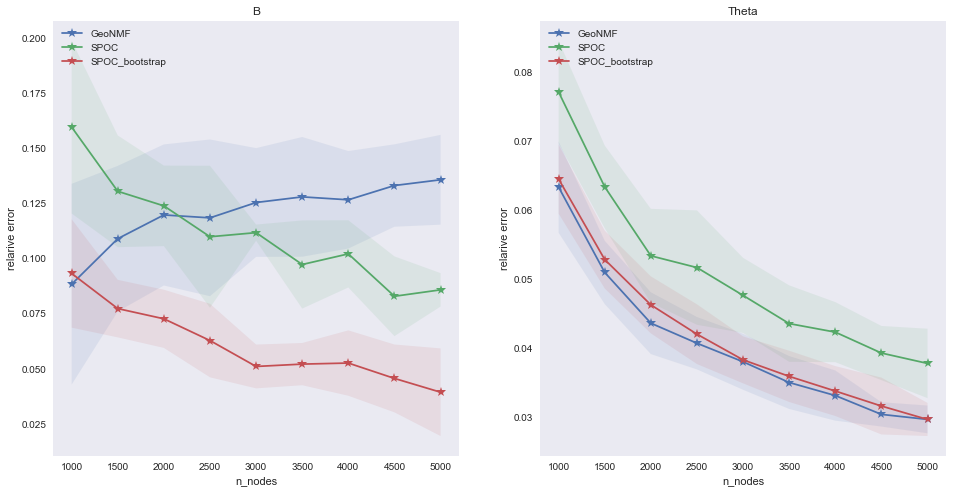

In [38]:
EXP_DATA = pd.read_csv("n_nodes.csv")

df = EXP_DATA.groupby(["n_nodes",  "method", "matrix"]).error.mean().reset_index()
std = EXP_DATA.groupby(["n_nodes",  "method", "matrix"]).error.std().reset_index()

fig = plt.figure(figsize=(16,8))

for method in df.method.unique():
    
    
    method_df = df[df["method"] == method]
    std_df = std[std["method"] == method]
    
    for num, matrix in enumerate(df.matrix.unique()):
        matrix_df = method_df[method_df["matrix"] == matrix]
        matrix_std = std_df[std_df["matrix"] == matrix]
        
        plt.subplot(1,2,num+1)
        plt.plot(matrix_df.n_nodes, matrix_df.error, label=method, marker='*', markersize=10)
        plt.fill_between(matrix_std.n_nodes, matrix_df.error - matrix_std.error, matrix_df.error + matrix_std.error,\
                         alpha=0.1)
        plt.xlabel("n_nodes")
        plt.ylabel("relarive error")
        plt.title(matrix)
        plt.legend(loc="upper left")
        matplotlib.rcParams.update({'font.size': 40})
        plt.grid()
        #plt.tick_params(axis='both', which='major', labelsize=16)
plt.savefig("n_nodes.png")